### Used libraries

In [17]:
import numpy as np
import scipy as sp
from skimage.draw import line_nd
import cv2
from copy import deepcopy
import matplotlib
from matplotlib import pyplot as plt
import ipywidgets as widgets

matplotlib.rcParams['figure.figsize'] = [8, 8]


### Chosing path to a file and parameters

In [18]:
wdg_path = widgets.Text(value='./example_photos/Kropka.jpg', placeholder='Type path to a file', description='Path to a file:')
wdg_scans = widgets.IntSlider(value=90, min=90, max=720, step = 90, description='Number of scans:')
wdg_detectors = widgets.IntSlider(value=180, min=90, max=720, step = 90, description='Number of detectors:')
wdg_opening = widgets.IntSlider(value=135, min=45, max=270, step = 45, description='Opening width:')

display(wdg_path)
display(wdg_scans)
display(wdg_detectors)
display(wdg_opening)


Text(value='./example_photos/Kropka.jpg', description='Path to a file:', placeholder='Type path to a file')

IntSlider(value=90, description='Number of scans:', max=720, min=90, step=90)

IntSlider(value=180, description='Number of detectors:', max=720, min=90, step=90)

IntSlider(value=135, description='Opening width:', max=270, min=45, step=45)

### Loading parameters

90 180 135


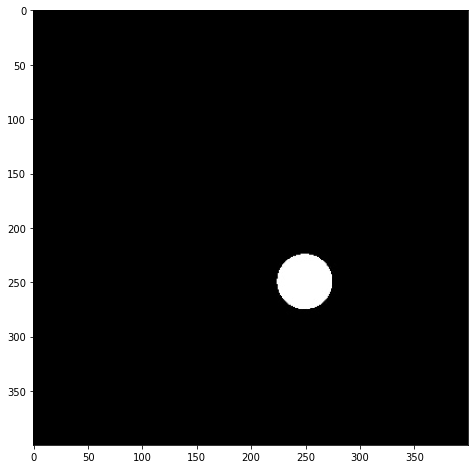

In [19]:
input_img = plt.imread(wdg_path.value)

if len(np.shape(input_img)) == 3:
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    
scans = wdg_scans.value
detectors = wdg_detectors.value
opening = wdg_opening.value

print(scans, detectors, opening)

plt.imshow(input_img, cmap = 'gray')
plt.show()

### Finding the circle described over an image

In [20]:
# Image shape
img_heigth, img_width = np.shape(input_img)
print("Shape:", img_heigth, img_width)

# Center of mass
cx = int(img_heigth / 2)
cy = int(img_width / 2)
print("Center:", cx, cy)

# Radius
radius = int(np.floor(0.5 * np.sqrt(img_heigth**2 + img_width**2)))
print("Radius:", radius)

Shape: 400 400
Center: 200 200
Radius: 282


### Scanning

In [21]:
alpha = 360 / scans
step = alpha
n = detectors
l = opening

shots = []
E = []
D = []

sinogram = []

# Prepare preview image so that emitters and detectors will be seen
border_width = max(2 * radius - img_width, 2 * radius - img_heigth)
preview_img = deepcopy(input_img)
preview_img = cv2.cvtColor(preview_img,cv2.COLOR_GRAY2RGB)
preview_img = cv2.copyMakeBorder(preview_img, border_width, border_width, border_width, border_width, cv2.BORDER_CONSTANT, value = (0,0,0))

for _ in range(scans):
    shots.append(deepcopy(preview_img))
    cv2.circle(shots[-1], (cx + border_width, cy + border_width), radius, (255,0,255), 1)

    # Calculating emiter's position
    xe = radius * np.cos(np.deg2rad(alpha))
    ye = radius * np.sin(np.deg2rad(alpha))

    E.append((int(cx + xe), int(cy + (-1)*ye)))

    # Drawing emiter over an image
    cv2.circle(shots[-1], (E[-1][0] + border_width, E[-1][1] + border_width), 7, (0,255,0), 3)

    D.append([])
    sinogram.append([])

    for i in range(n):
        # Calculating detector's position
        xd = radius * np.cos(np.deg2rad(alpha + 180 - l / 2 + i * (l / (n-1))))
        yd = radius * np.sin(np.deg2rad(alpha + 180 - l / 2 + i * (l / (n-1))))

        D[-1].append((int(xd + cx), int((-1)*yd + cy)))

        # Drawing detector on the image
        cv2.circle(shots[-1], (D[-1][-1][0] + border_width, D[-1][-1][1] + border_width), 3, (255,0,0), 1)

        # Calculating points of the line
        line_x_points, line_y_points = line_nd(E[-1], D[-1][-1])

        brightness = 0
        sumof = 0

        for (x, y) in zip(line_x_points, line_y_points):
            # Drawing line on the image
            cv2.circle(shots[-1], (x + border_width, y + border_width), 0, (0,0,255), -1)

            # Calculating mean brightness
            if x >= 0 and x < img_heigth and y >= 0 and y < img_width:
                brightness += input_img[x][y]
                sumof += 1

        # # Adding results to sinogram
        if sumof != 0:
            brightness = brightness / sumof
        else:
            brightness = 0
        sinogram[-1].append(brightness)

    alpha += step

### Scannig step by step

In [22]:
def display_shot(n):
    plt.imshow(shots[n])
    plt.show()
    
widgets.interact(display_shot, n = (0, scans - 1, 1))

interactive(children=(IntSlider(value=44, description='n', max=89), Output()), _dom_classes=('widget-interact'…

<function __main__.display_shot(n)>

### Sinogram

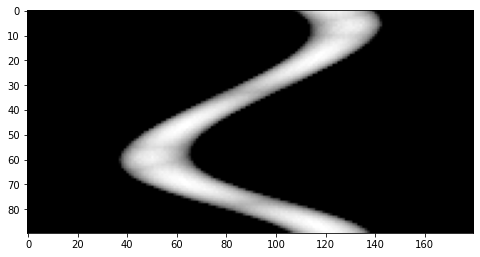

In [23]:
plt.imshow(sinogram, cmap='gray')
plt.show()

### Sinogram filtration

In [24]:
kernel = []
for k in range(-10, 11):
    if k == 0:
        kernel.append(1)
    else:
        if k % 2 == 0:
            kernel.append(0)
        else:
            kernel.append((-4 / np.pi**2)/(k**2))

plt.plot([k for k in range(21)], kernel)
plt.show()

for i in range(len(sinogram)):
    sinogram[i] = np.convolve(sinogram[i], kernel, mode='same')

plt.imshow(sinogram, cmap='gray')
plt.show()


### Backtracing

In [25]:
backshots = []
blank_image = np.zeros((img_heigth, img_width))

for i in range(len(sinogram)):
    if i == 0:
        backshots.append(deepcopy(blank_image))
    else:
        backshots.append(deepcopy(backshots[-1]))
    for j in range(n):
        line_x_points, line_y_points = line_nd(E[i], D[i][j])
        for (x, y) in zip(line_x_points, line_y_points):
            # Calculating mean brightness
            if x >= 0 and x < img_heigth and y >= 0 and y < img_width:
                backshots[-1][x][y] += sinogram[i][j]


### Backstracking step by step

In [26]:
def display_backshot(n):
    plt.imshow(backshots[n], cmap = 'gray')
    plt.show()
    
widgets.interact(display_backshot, n = (0, scans - 1, 1))

interactive(children=(IntSlider(value=44, description='n', max=89), Output()), _dom_classes=('widget-interact'…

<function __main__.display_backshot(n)>